# Assignment 1: Tabular Methods

Name: Chun-Han Yao

ID: A53234899

This exercise requires you to solve a simple grid-world problem called 'FrozenLake-v0' in OpenAI Gym.  We will solve the problem in two different ways. First we will solve the problem using dynamic programming, thus requiring a model of the system. Second we will do it using model-free temporal difference (Q-Learning). Finally, as a bonus you may also show it learning using a naive approach called hill-climbing. 

### Required for all 
#### Set up environment

In [1]:
%matplotlib inline
import gym
import numpy as np
from matplotlib import pyplot as plt
env = gym.make('FrozenLake-v0')
env = env.unwrapped

nA = env.nA
nS = env.nS

env.render()


SFFF
FHFH
FFFH
HFFG


#### Pre. Test Policy Function
Write a function to test a policy. Return the average rate of successful episodes over 100 trials. 

In [2]:
def testPolicy(policy):
    
    #%% ---> start of code
    
    n_episode = 100
    n_success = 0
    
    for i in range(n_episode):
        s = env.reset()
        done = False
        
        while not done:
            action = policy[s]
            s, reward, done, _ = env.step(action)

        if reward > 0:
            n_success += 1
                
    percentSuccess = n_success / n_episode
    
    #%% <--- end of code
    
    return percentSuccess

## Model-based Learning

### 1. Policy Iteration
Perform policy iteration on the Frozenlake example. 


#### 1.1 Find the system model
First, model $T(s,a,s')$ and $R(s,a,s')$ over 100000 randomly initializations.

In [3]:
def learnModel():
    
    #%% ---> start of code
    
    T = np.zeros([nS, nA, nS])
    R = np.zeros([nS, nA, nS])
    
    for i in range(100000):
        state = env.reset()
        env.s = np.random.choice(nS)
        
        s = env.s
        a = np.random.choice(nA)
        next_s, reward, _, _ = env.step(a)

        T[s, a, next_s] += 1
        R[s, a, next_s] += reward
    
    for s in range(nS):
        for a in range(nA):
            for next_s in range(nS):
                if T[s, a, next_s] > 0:
                    R[s, a, next_s] /= T[s, a, next_s]
                
            T[s,a,:] /= np.sum(T[s,a,:])
    
    #%% <--- end of code
    
    return R, T


#first learn the model    
[R, T] = learnModel()

print(R[14,:,:])
print(T[14,:,:])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.32034923  0.          0.          0.322364
   0.35728677  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.33333333  0.34612924  0.32053743]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.30865007  0.          0.          0.
   0.34600262  0.34534731]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.35544431  0.          0.
   0.33541927  0.          0.309

#### 1.2 What does the transition model tell you about the stochastic behavior of actions? What does it tell you about the stochasticity  of the rewards? What would you expect an optimal agent's policy to do?

ans: 
1. The transition model T shows that when the agent takes an action to move forward, the probabilities of ending up in the front, at the left, and at the right are all around 1/3.

2. The reward matrix R shows that the reward of each trasition (s, a, s') is deterministic. That is, the reward is either 1 for s'=G or 0 for s'=H.

3. An optimal agent's policy would follow the directions towards the goal (G), by either moving towards the state with higher state value or taking the step with a higher Q value.

#### 1.3 Write a function for Policy Evaluation

In [4]:
#runPolicyEvaluation:
def runPolicyEvaluation(policy, V, R, T, discount_factor):
    
    #%% ---> start of code
    
    threshold = 1e-6
    max_iter = 1000
    
    for i in range(max_iter):
        V_new = np.zeros(nS)
        
        for s in range(nS):
            for next_s in range(nS):
                a = policy[s]
                V_new[s] += T[s,a,next_s] * (R[s,a,next_s] + discount_factor * V[next_s])
            
        if np.max(np.abs(V_new - V)) < threshold:
            break
            
        V = V_new
    
    #%% <--- end of code
    
    return V_new

#### 1.4 Run Policy iteration.
and show a bar graph of successful runs vs iteration on the policy. Use a discount factor of 0.98, and terminate policy  after 40 iterations of policy updates.  Plot the percentSuccesses at every iteration (i.e. the return of the testPolicy function).

Policy iteration policy: [0 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]


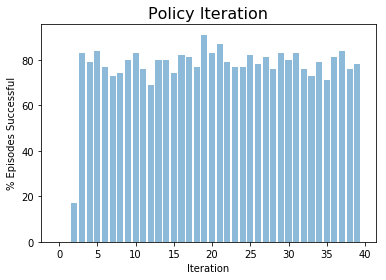

In [5]:
#%% ---> start of code

max_iter = 40
discount_factor = 0.98
percentSuccesses = np.zeros(max_iter)

V = np.zeros(nS)
old_policy = np.zeros(nS, dtype=np.int32)


for i in range(max_iter):    
    V_new = runPolicyEvaluation(old_policy, V, R, T, discount_factor)
    policy = np.zeros(nS, dtype=np.int32)
    
    for s in range(nS):       
        action_values = np.zeros(nA)
        
        for a in range(nA):
            for p, next_s, reward, done in env.P[s][a]:                
                action_values[a] += T[s,a,next_s] * (R[s,a,next_s] + discount_factor * V_new[next_s])
                    
        policy[s] = np.argmax(action_values)
    
    V = V_new
    old_policy = policy   
    percentSuccesses[i] = testPolicy(policy)    

#%% <--- end of code

    
# plot improvement over time
plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration') 
plt.title('Policy Iteration',fontsize=16)  
print('Policy iteration policy:', policy)

## Model-Free Learning

### 2 Q Value-Iteration (Q-Learning)

#### 2.1 Set up a Q learning function
Set your exploration rate to 1-episode_num/total_num_of_episodes for linear convergence from completely random action selection to a greedy policy. Return a set of policies (at 5%, 10%,...100% of the total number of episodes) so that in the later section you can perform policy evaluation on intermediate Q-tables and show progress.

In [6]:
def runQLearning(learning_rate, discount_factor, num_of_episodes, Q0, explore_type='linear'):
    
    #%% code starts here
    
    Q = Q0
    Q_saved = []
    
    for i in range(num_of_episodes):         
        s = env.reset()
        done = False
        
        while not done:
            if explore_type == 'log':
                thres = 1000 / (1000+i+1)
            else:
                thres = 1 - (i+1)/num_of_episodes
                
            if np.random.rand() > thres:
                action = np.argmax(Q[s,:])
            else:
                action = np.random.choice(nA)
            
            next_s, reward, done, _ = env.step(action)
            Q[s, action] += learning_rate * (reward + discount_factor * np.max(Q[next_s,:]) - Q[s,action])
            s = next_s
        
        if i % (num_of_episodes/10) == 0:
            Q_saved.append(Q.copy())
    
    #%% code ends here
    
    Q_saved.append(Q.copy()) #save last Q
    return Q_saved

#### 2.1 Perform Q-learning. 
Show policies during intermediate phases of Q-learning, at 0, 10%, 20%,...,100% of the total episodes during training. Set a learning rate of 0.98 and a discount factor of 0.95. Start with a zero-filled Q-table. Run 10000 episodes. Plot the bar graph of the success rate over time to visualize the improvements to success rate the new policies are providing. 

Q-learning (linear) policy: [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


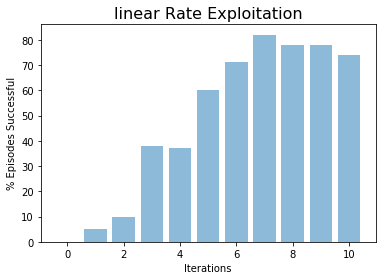

In [7]:
#%% ---> start of code

learning_rate = 0.02
discount_factor = 0.95
num_of_episodes = 10000

Q0 = np.zeros([nS, nA])
Q_saved = runQLearning(learning_rate, discount_factor, num_of_episodes, Q0, 'linear')
percentSuccesses = np.zeros(len(Q_saved))

for i in range(len(Q_saved)):
    policy = np.argmax(Q_saved[i], axis=1)
    percentSuccesses[i] = testPolicy(policy)
    #print('Q-learning (linear) policy:', policy)
        
#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('linear Rate Exploitation', fontsize=16)
print('Q-learning (linear) policy:', policy)

#### 1.4 Log Rate Exploration

Run Q-learning for a log exploration rate, $\frac{1000}{1000+\text{episode_num}}$, for 10,000 episodes. Perform policy evaluation and plot the success rate over time. You may find setting Q0 to a random number initialization helps (set it to something very small, i.e. 0.000001\*rand(), since setting it to zero sets a fixed seed).

Q-learning (log) policy: [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 1]


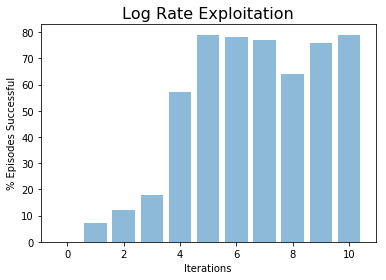

In [8]:
#%% ---> start of code

learning_rate = 0.02
discount_factor = 0.95
num_of_episodes = 10000

Q0 = 1e-6 * np.random.rand(nS, nA)
Q_saved = runQLearning(learning_rate, discount_factor, num_of_episodes, Q0, 'log')
percentSuccesses = np.zeros(len(Q_saved))

for i in range(len(Q_saved)):
    policy = np.argmax(Q_saved[i], axis=1)   
    percentSuccesses[i] = testPolicy(policy)
    #print('Q-learning (log) policy:', policy)

#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('Log Rate Exploitation', fontsize=16)
print('Q-learning (log) policy:', policy)

### BONUS: Hill Climbing (25%, granted only if Parts 1 and 2 are complete)

Demonstrate hill climbing, where your Q values are chosen randomly, and you save improvements, with new Q values to try as $$Q_{test}\leftarrow Q_{best}+rand(S,A)$$
Plot the a bar graph with x-axis labelling the iteration number when an improvement occurred, and y axis as the % of successful episodes. Run on N = 1000 iterations of hill climbing, with 100 episodes per iteration. 

[0 3 3 1 0 3 0 1 3 1 0 1 3 2 1 0] : Hill-climbing policy


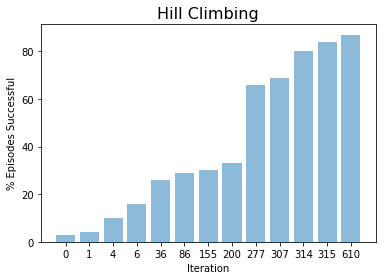

In [18]:
#%% ---> start of code

N = 1000
improvementsIndex = []
percentSuccesses = []

Q_best = 1e-6 * np.random.rand(nS, nA)
percentSuccess_best = 0


for i in range(N):
    Q_test = Q_best + np.random.rand(nS, nA)
    policy = np.argmax(Q_test, axis=1)
    percentSuccess = testPolicy(policy)
    
    if percentSuccess > percentSuccess_best:
        Q_best = Q_test
        percentSuccess_best = percentSuccess
        improvementsIndex.append(i)
        percentSuccesses.append(percentSuccess)

#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(improvementsIndex)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.xticks(np.arange(len(improvementsIndex)),improvementsIndex) 
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration')
plt.title('Hill Climbing',fontsize=16)
print(policy,': Hill-climbing policy')